In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwavoriginal = np.zeros((ns,nr,nt)), - \
         np.zeros((ns,nr,nt))
for iy,y0 in enumerate(y):
    G[iy],Gwavoriginal[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwavoriginal = G*tap,Gwavoriginal*tap



Gwav = Gwavoriginal
Gwavoriginal.shape

(101, 61, 400)

In [3]:
# Add negative part to operator and model
ns = Gwav.shape[0]
m     = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav  = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

m.shape

(799, 61)

In [4]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)

# dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(2*nt-1, ns)


MDCop.shape

(80699, 48739)

In [5]:

MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
d =  torch.from_numpy(d.astype(np.float32))
m  =  torch.from_numpy(m.astype(np.float32))
Gwav2 = torch.from_numpy(Gwav2.astype(np.float32))

d1 = MDCop.apply(m.flatten())
d1 = d1.view(2*nt-1, ns)

In [6]:
nv=1
class GwavSGD(nn.Module):
  def __init__(self,nt,nv,dt,dr,ns):
    self.nt = nt
    self.nv = nv
    self.dt = dt
    self.dr =dr
    self.ns = ns
    super().__init__()


  def forward(self,model, Gwav_fft):
    
    MDCop=MDC(Gwav_fft, nt=2*self.nt-1, nv=self.nv, dt=self.dt, dr=self.dr, 
          twosided=True, transpose=False)
    
    MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
    
    data = MDCop.apply(model.flatten())
    data = data.view(2*self.nt-1, self.ns)
 

    return data


In [7]:
lossdict = {}
enormdict={}
avgdict ={}

In [8]:
n_epochs = 100
learning_rate = 70

optimizer = 'SGD'

In [9]:
def advoptMDD(model, optimizer, lr):
  if optimizer == 'SGD':
 
      optimizer = torch.optim.SGD([model], lr = lr, weight_decay =0, momentum=0.9, dampening=0, nesterov=True)


  elif optimizer == 'Adadelta':
   
      optimizer = torch.optim.Adadelta([model], lr =lr, rho =0.9,weight_decay=0)
 

  elif optimizer == 'Adam':
   
      optimizer= torch.optim.Adam([model], lr=lr, eps =1e-8)
   
  elif optimizer == 'RMSprop':
   
      optimizer= torch.optim.RMSprop([model], lr =lr, centered=True, alpha=0.9)
    

  elif optimizer == 'Adagrad':
    
      optimizer= torch.optim.Adagrad([model], lr = lr, eps = 1e-10, lr_decay =0)
  

  return optimizer



  


In [10]:

def advancedSolvers(GwavSGD,model, optimizer, lr, n_epochs):
  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)
 

  GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
  lossHist=[]
  lossavg=[]
  enormHist=[]
  for epoch in range(n_epochs):
    data = GwavTorch(model,Gwav_fft)
    lost= criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    
    lossHist.append(loss.item())
   
    avg = sum(lossHist) / len(lossHist)
    lossavg.append(avg)
    
    enorm1 = np.linalg.norm(model.detach().numpy()/model.detach().numpy().max() - m.detach().numpy()/m.detach().numpy().max())
    enormHist.append(enorm1)
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg:.4f}')
  

    lossdict[optimizer] = lossHist
    enormdict[optimizer] = enormHist
    
  return lossHist, enormHist

In [11]:
# This solvers performs best for Adam, Adagrad, RMSprop at low lr

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True


lossHist, enormHist = advancedSolvers(GwavSGD,model,optimizer = optimizer, lr =learning_rate, n_epochs=n_epochs)

epoch: 10, loss : 0.0005, loss avg : 0.0023
epoch: 20, loss : 0.0001, loss avg : 0.0012
epoch: 30, loss : 0.0000, loss avg : 0.0008
epoch: 40, loss : 0.0000, loss avg : 0.0006
epoch: 50, loss : 0.0000, loss avg : 0.0005
epoch: 60, loss : 0.0000, loss avg : 0.0004
epoch: 70, loss : 0.0000, loss avg : 0.0004
epoch: 80, loss : 0.0000, loss avg : 0.0003
epoch: 90, loss : 0.0000, loss avg : 0.0003
epoch: 100, loss : 0.0000, loss avg : 0.0003


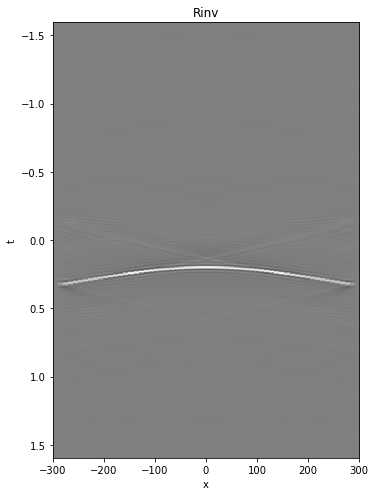

In [12]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

ax1.set_title('Rinv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

plt.tight_layout()

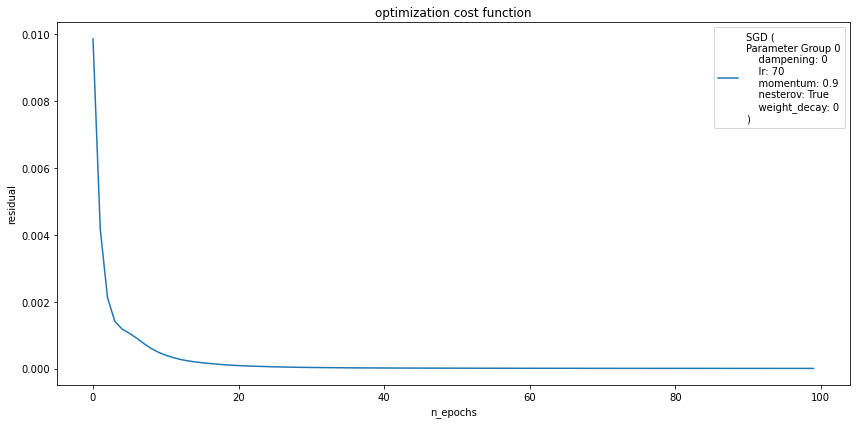

In [13]:
fig = plt.figure(figsize= (12,6))

for loss in (lossdict.keys()):
  
  plt.plot(lossdict[loss], label = loss)
  
  plt.xlabel('n_epochs')
  plt.ylabel('residual')
  plt.title('optimization cost function')
  plt.legend()
  plt.tight_layout()



## Data from LSQR solver ##


In [14]:
f = np.load('MDD_basic_norms.npz') 

lsqr_cost = f['cost'] 
lsqr_enorm = f['enorm']


# lsqr_cost = lsqr_cost*Gwav2.shape[0]

In [15]:
print(lsqr_enorm)

[12.08911119 11.43971978 11.72038457 11.45521418 10.86057757 10.57971187
 10.35334843 10.21186775 10.08066343  9.92029995  9.75863115  9.62936923
  9.50049142  9.37698027  9.25685787  9.15302202  9.07836286  9.01912625
  8.96295574  8.90060903  8.84756432  8.80334174  8.76197724  8.72299692
  8.68172871  8.64137618  8.60826031  8.57484197  8.54341839  8.51858269
  8.49619462  8.47674629  8.45318504  8.42380469  8.39579152  8.37481862
  8.35256678  8.33058931  8.30783449  8.28893923  8.27583468  8.25634195
  8.23910796  8.22264148  8.20901885  8.19379593  8.1788828   8.16633055
  8.15656641  8.14544915]


In [16]:
# enorm2t = lsqr_enorm**2  / (m.detach().numpy().size)
# print(enorm2t)

**Comparing cost function of MDD and optimizer**

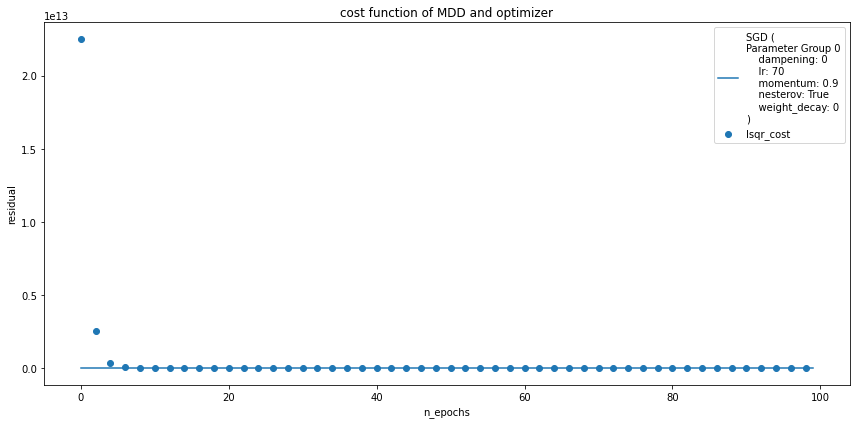

In [17]:


for loss in (lossdict.keys()):
  fig = plt.figure(figsize= (12,6)) 
  plt.plot(lossdict[loss], label = loss)
 
  plt.scatter(np.arange(0,len(lossdict[loss]), n_epochs/len(lsqr_cost)),lsqr_cost,label ='lsqr_cost')
  plt.xlabel('n_epochs')
  plt.ylabel('residual')
  plt.title('cost function of MDD and optimizer')
  plt.legend()
  plt.tight_layout()




**Comparing ||e||_2 of MDD model and Optimizer model**

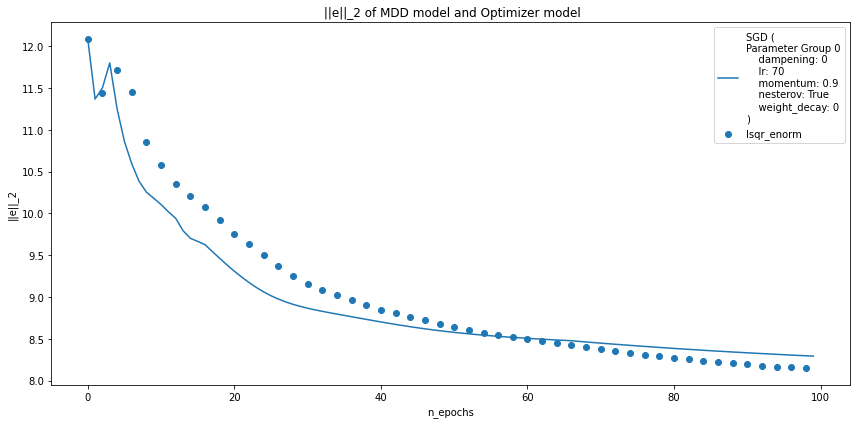

In [18]:
for enorm in enormdict.keys():
  fig = plt.figure(figsize= (12,6))
  plt.plot(enormdict[enorm], label=enorm)
  plt.scatter(np.arange(0,len(enormdict[enorm]), n_epochs/len(lsqr_enorm)),lsqr_enorm, label = "lsqr_enorm")
  plt.ylabel('||e||_2')
  plt.xlabel('n_epochs')
  plt.title(" ||e||_2 of MDD model and Optimizer model")
  plt.legend()
  plt.tight_layout()

